## Introduction
The primary goal of this notebook is to obtain the map matching for GPS data. To accomplish this goal, we are going to parse the trajectories, analyze the travel speed and duration as well as the departures of each trip

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns

import os
import glob
import math
import numpy as np

import calendar
from datetime import datetime
import time

import requests
import json 

## Load the data

In [2]:
# Load the data from the parsed trajectories
data=pd.read_csv('data_parsed.csv')

In [5]:
idx = #add an id
test=data[data['activity_id']==idx]

This image shows an example fo why we need to parse trajectories before using the data. We took a trip registered by the app and parsed it. We can see how a single trip is divided into 6 other trips/tours in which the latitude of the person changes over the time. Also, we can see how points classified as `stays` have a similar latitutude over the time

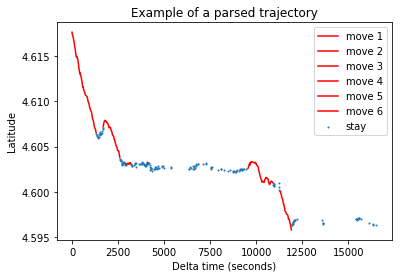

In [6]:
color=['r','y','b','g','p','v']
for i in test['stays'].unique():
    if i!=0:
        plt.plot(test[test['stays']==i]['delta_seconds'],test[test['stays']==i]['lat'],'r');
    else:
        plt.scatter(test[test['stays']==i]['delta_seconds'],test[test['stays']==i]['lat'],1);
plt.xlabel ('Delta time (seconds)');
plt.ylabel ('Latitude');
plt.legend(['move 1','move 2','move 3','move 4','move 5','move 6','stay']);
plt.title('Example of a parsed trajectory');
plt.savefig('parsed_example.eps', format='eps', dpi=1000)

In [7]:
# filter the data that has stays greater than  so that we consider only moving people
data=data[data['stays']>0]

In [8]:
# Create new activity ids for the "new" trips
data.loc[:,'new_activity_id']=data['activity_id'].astype('str')+'-'+data['stays'].astype('int').astype('str')

## Trips Description

### Calculate instantaneous speed

In [10]:
# Function to calculte distance
def calculate_dist (lat_1,lat_2,lon_1,lon_2):
    if (math.isnan(lat_1)|math.isnan(lat_2)|math.isnan(lon_1)|math.isnan(lon_2)):
         return float('nan')         
    elif ((lat_1==lat_2)&(lon_1==lon_2)):
        dist=0.0
    else:
        R_aver = 6374;
        lat_1 = math.radians(lat_1)
        lon_1 = math.radians(lon_1)
        lat_2 = math.radians(lat_2)
        lon_2 = math.radians(lon_2)
        aux=math.cos(lat_1)*math.cos(lat_2)*math.cos(lon_1-lon_2) + math.sin(lat_1)*math.sin(lat_2)
        if aux>1:
            aux=1
        dist = R_aver * math.acos(aux);
            
    return dist*1000  

In [11]:
data.reset_index(inplace=True)

In [12]:
data.rename(columns={'lat':'y1','lon':'x1'},inplace=True)

In [13]:
# Add the following point to each record to avoid using loops
data.loc[1:,'x2']=data['x1'].tolist()[0:-1]
data.loc[1:,'y2']=data['y1'].tolist()[0:-1]

In [16]:
# calculate instantaneous distance
data.loc[:,'distance_inst']=data.apply(lambda row: calculate_dist(row['y1'],row['y2'],\
                                row['x1'],row['x2']),axis=1)

In [17]:
# Get the time
data.loc[:,'date_1']=data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))

In [18]:
# Add the time for the destination
data.loc[1:,'date_2']=data['date'].tolist()[0:-1]
data.loc[0,'date_2']=data['date'][0]
data.loc[:,'date_2']=data['date_2'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))

In [19]:
# Delta time (instantaneous)
data.loc[:,'delta_sec']=(data['date_1']-data['date_2']).apply(lambda x: x.total_seconds())

In [20]:
# Calculate Speeds
data.loc[:,'speed_ms']=data['distance_inst']/data['delta_sec']
data.loc[:,'speed_kmh']=data['speed_ms'].apply(lambda x: (x/1000)*3600)

In [22]:
# Use only the speed between same activity IDs. Check that two continuous data points belong to the same
# activity_id to calculate mean speed
data.loc[1:,'activity_id2']=(data['new_activity_id'].tolist()[0:-1])
data.loc[:,'same_activity']=(data['new_activity_id']==data['activity_id2'])*1

In [23]:
# Filter the data so that we use only the same activity ids for the speeds
data=data[data['same_activity']==1]

Set a speed limit for the speeds which is 30kmh.

In [28]:
max_speed=30

In [30]:
# Filter the speeds that are reasonable
data=data[data['speed_kmh']<=max_speed]

In [31]:
mean_speed=data.groupby(['new_activity_id'])[['speed_kmh']].mean()

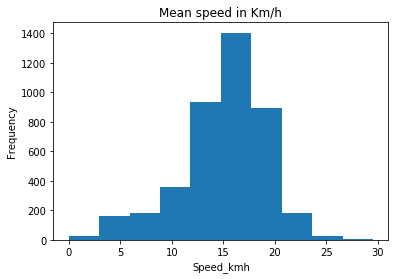

In [32]:
plt.hist(mean_speed['speed_kmh'],bins=10)
plt.xlabel('Speed_kmh')
plt.ylabel('Frequency')
plt.title('Mean speed in Km/h')
plt.savefig('speeds.eps', format='eps', dpi=1000)

# Trip Duration

In [81]:
def duration(data):
    minutes=(data['date_1'].max()-data['date_1'].min()).total_seconds()/60
    return minutes

In [82]:
durations=data.groupby('new_activity_id').apply(duration)

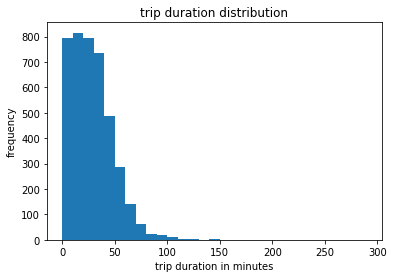

In [83]:
# Filter the trips of more than 5 hours
plt.hist(durations[durations<300],bins = list(range(0,300,10)));
plt.xlabel('trip duration in minutes');
plt.ylabel('frequency');
plt.title('trip duration distribution');
plt.savefig('duration.eps', format='eps', dpi=1000)

In [84]:
durations.describe()

count    4179.000000
mean       28.407442
std        20.033622
min         0.000000
25%        13.250000
50%        25.833333
75%        39.958333
max       185.933333
dtype: float64

In [85]:
data_filtered=pd.DataFrame(durations[durations<300].reset_index())['new_activity_id'].tolist()

In [2]:
# Thanks to the parsing, we did not get any trip longer than 300 minutes, thus, buth lists have equal lenght
len(data_filtered),len(data['new_activity_id'].unique())

# Departures analysis

In [87]:
data=data[data['new_activity_id'].isin(data_filtered)]

In [88]:
len(data['new_activity_id'].unique()),len(data['new_activity_id'].unique())

(4179, 4179)

In [89]:
data.loc[:,'hour']=data['date'].apply(lambda x: datetime.strptime(x[11:],'%H:%M:%S').hour+datetime.strptime(x[11:],\
    '%H:%M:%S').minute/60.0 )

In [90]:
data.loc[:,'day_num']=data['date_1'].apply(lambda x: x.weekday())
data.loc[:,'day_name']=data['date_1'].apply(lambda x: calendar.day_name[x.weekday()])

In [91]:
data_departures=data.drop_duplicates(subset='new_activity_id',keep='first')

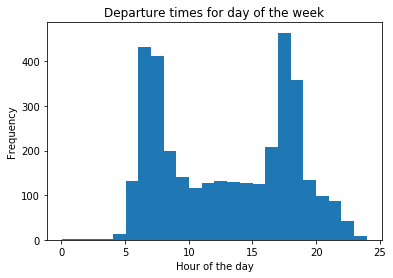

In [92]:
data_dw=data_departures[data_departures['day_num']<5]
plt.hist(data_dw['hour'],bins=24);
plt.xlabel('Hour of the day');
plt.ylabel('Frequency');
plt.title('Departure times for day of the week');
plt.savefig('week.eps', format='eps', dpi=1000)

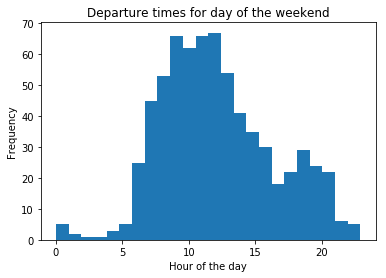

In [93]:
data_dnw=data_departures[data_departures['day_num']>=5]
plt.hist(data_dnw['hour'],bins=24);
plt.xlabel('Hour of the day');
plt.ylabel('Frequency');
plt.title('Departure times for day of the weekend');
plt.savefig('weekend.eps', format='eps', dpi=1000)

### Figures formatted for paper

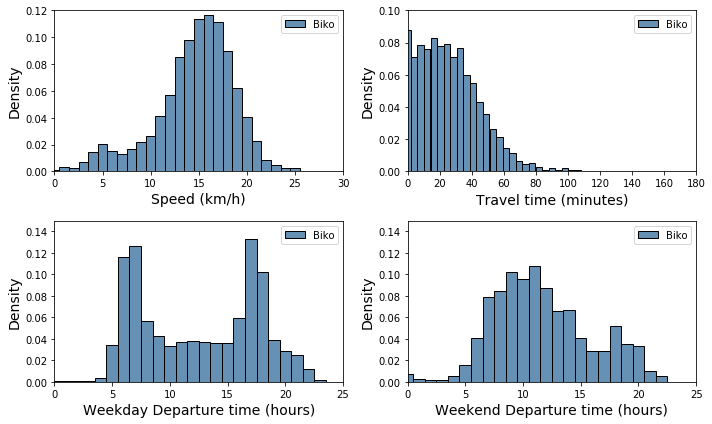

In [94]:
nb, b = np.histogram(mean_speed['speed_kmh'], bins = np.linspace(0,30,31),density = True)
b = b[:-1]
frac = np.divide(nb, float(np.sum(nb)))

n_dur, dur = np.histogram(durations[durations<300], bins = np.linspace(0,180,45), density = True)
dur = dur[:-1]
frac_dur = np.divide(n_dur, np.sum(n_dur))

n_week, week = np.histogram(data_dw['hour'], bins = np.linspace(0,25,26), density = True)
week = week[:-1]
frac_week = np.divide(n_week, np.sum(n_week))

n_weekend, weekend = np.histogram(data_dnw['hour'], bins = np.linspace(0,25,26), density = True)
weekend = weekend[:-1]
frac_weekend = np.divide(n_weekend, np.sum(n_weekend))


#######
plt.figure(figsize=(10,6))
#00BFFF
#6691B4 azul inicial
plt.subplot(2,2,1)
plt.bar(b, frac, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.legend()
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
plt.xlim(0,30)
plt.ylim(0,0.12)
plt.xlabel("Speed (km/h)",size=14)
plt.ylabel("Density",size=14)
plt.tight_layout()

######
plt.subplot(2,2,2)
# plt.bar(b, frac, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.bar(dur, frac_dur, width=4, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.legend()
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
plt.xlim(0,180)
plt.ylim(0,0.1)
plt.xlabel("Travel time (minutes)",size=14)
plt.ylabel("Density",size=14)
plt.tight_layout()


######
plt.subplot(2,2,3)
# plt.bar(b, frac, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.bar(week, frac_week, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.legend()
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
plt.xlim(0,25)
plt.ylim(0,0.15)
plt.xlabel("Weekday Departure time (hours)",size=14)
plt.ylabel("Density",size=14)
plt.tight_layout()

######
plt.subplot(2,2,4)
# plt.bar(b, frac, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.bar(weekend, frac_weekend, width=1, linewidth=1, edgecolor='#000000', color='#6691B4',alpha=1, label="Biko")
plt.legend()
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
plt.xlim(0,25)
plt.ylim(0,0.15)
plt.xlabel("Weekend Departure time (hours)",size=14)
plt.ylabel("Density",size=14)
plt.tight_layout()

plt.savefig('./img/descriptive.png')

# Fourth Part: Map Matching

### Data preparation

In [52]:
data_all=data[['date','activity_id','new_activity_id','user_id','altitude','stays','x1','y1']]

In [53]:
# Delete points where the person is not moving
data_all=data_all[data_all['stays']>0]
data_all.shape,data.shape

((1419217, 8), (1419217, 25))

In [54]:
len(data_all.new_activity_id.unique())

4179

In [55]:
# Prepare the coordinates for the link
data_all.loc[:,'coordinates_str']=(data_all['x1']).astype(str)+','+(data_all['y1']).astype(str)

In [56]:
data_all.reset_index(inplace=True)

### Calculate the delta time 

In [58]:
data_all.loc[:,'date_1']=data_all['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))

In [3]:
# Sort the data to be in chronologycal order from the oldest to the newest date
data.sort_values(['activity_id','date_1'],inplace=True)
data.head()

In [60]:
# function to calculate the delta seconds from the start of an activity id to each point recoded
def total_second(arr):
    return (arr-arr.min())

In [61]:
# Use the total_seconds function to create a list
cum= data[['date_1']].groupby(data['activity_id']).transform(total_second)

In [62]:
cum.rename(columns={'date_1':'delta_seconds'},inplace=True)

In [63]:
# Add a column where we see the seconds from the start of the trip
merge=pd.merge(data_all,cum,left_on='index',right_index=True,how='left')

In [5]:
# check that no duplicates were created
merge.shape,data_all.shape

In [65]:
merge.loc[:,'timestamp']=merge['delta_seconds'].apply(lambda x: str(int(x.total_seconds())))

In [66]:
data_all=merge.copy()

### Extract coordinates 

In [207]:
def extract_coordinates (data):
    list_coordinates=data['coordinates_str'].tolist()
    return ';'.join(list_coordinates)    

In [208]:
def extract_times (data):
    list_times=data['timestamp'].tolist()
    return ';'.join(list_times)    

### API Query
Note: The online OSRM service allows map matching for the auto mode only. To allow other modes, a local version of the service has to be set. We followed this post to set our local version: https://github.com/Project-OSRM/osrm-backend/wiki/Running-OSRM

In [209]:
def api_query(profile,coordinates,times):
    url_base='http://localhost:5000/match/v1/' # link to make local queries 
    url=url_base+profile+'/'+coordinates+'?steps=false&geometries=polyline&overview=full&annotations=true&tidy=true&timestamps='+times
    # Make the query
    response = requests.get(url)
    result=response.text
    dict_result=json.loads(result)
    return dict_result

### Read Results

In [632]:
def read_result(result,new_activity_id,i):
    list_df=[]
    tracepoints=pd.DataFrame(index=[list(range(len(result['tracepoints'])))],columns=[])
    tracepoints.loc[:,'points']=result['tracepoints']
    tracepoints.loc[:,'new_activity_id']=new_activity_id
    tracepoints.loc[:,'repeat_num']=i
    for match in range(len(result['matchings'])):
        frame=pd.DataFrame(result['matchings'][match]['legs'])
        frame.loc[:,'match']=match
        frame.loc[:,'repeat_num']=i
        frame.loc[:,'new_activity_id']=new_activity_id
        frame.loc[:,'confidence']=result['matchings'][match]['confidence']
        frame.loc[:,'code']=result['code']
        list_df.append(frame)
    dfs=pd.concat(list_df)
    return dfs,tracepoints
    

### Table with each activity and node sequence

In [528]:
profile='bicycle'
map_match=pd.DataFrame(index=[],columns=['new_activity_id','legs','node_sequence','error'])
idx=0
# Limit is a variable with a function to stop querying from time to time, this was necessary when doing online queries.
limit=100

In [531]:
idx=0
dfs=[]
tracepoints=[]
for activity in data_all['new_activity_id'].unique():
    # the program cannot handle more than a 100 points at the same time
    repeat_number=np.ceil(len(data_all[data_all['new_activity_id']== activity])/100)
    for i in range (1,int(repeat_number)+1):
        # We divide the data in subsets of a 100 points so that the program does not crash
        subset=data_all[data_all['new_activity_id']==activity].reset_index()[(i-1)*100:i*100]
        list_coordinates=extract_coordinates(subset) 
        list_times=extract_times(subset) 
        result=api_query(profile,list_coordinates,list_times)        
        if result['code']!='Ok':
            map_match.loc[idx,'new_activity_id']=activity
            map_match.loc[idx,'error']=1
            map_match.loc[idx,'node_sequence']=result['code']
            idx=idx+1
        else:            
            map_match=map_match.astype('object')
            map_match.loc[idx,'new_activity_id']=activity
            map_match.loc[idx,'error']=0
            result_read=read_result(result,activity,i)
            dfs.append(result_read[0])
            tracepoints.append(result_read[1])
            idx=idx+1
            if idx==limit:
                time.sleep(5)
                limit=limit+100
# Save the data after running
tracepoints=pd.read_csv('tracepoints.csv')
new=pd.concat(dfs)
new.to_csv('matched.csv')

In [7]:
# Reopen data
new=pd.read_csv('matched.csv')

In [8]:
# compare the unique activity id on the `new` dataframe so that we can know how many activities the OSRM was not able to locate
len(new['new_activity_id'].unique())

### Filter data and create the pairs

In [79]:
new.reset_index(inplace=True)

In [80]:
import ast

In [81]:
new.loc[:,'nodes']=new['annotation'].apply(lambda x: ast.literal_eval(x)['nodes'])

In [82]:
new.loc[:,'pairs']=new['nodes'].apply(lambda x: list(zip(x[0:-1],x[1:])))

In [83]:
def unique_nodes(data):
    list_list=data['pairs'].tolist()
    flat_list=[y for x in list_list for y in x]
    list_pairs=pd.Series(flat_list).unique()
    return list_pairs
# you can try both options
# uniques=[list_nodes[0]]
# for i in range(1,len(list_nodes)):
#     if not list_nodes[i]==list_nodes[i-1]:
#         uniques.append(list_nodes[i])

In [84]:
# Need to keep with unique nodes since the OSRM may have repeated sequence of nodes from a trace to the other. 
df=pd.DataFrame(data=new.groupby(['new_activity_id','confidence'],sort=False).apply(unique_nodes))

In [85]:
df.reset_index(inplace=True)

In [86]:
# Edge sequence is the sequence of nodes a person is travelling through translated into an edge for future network analysis
df.rename(columns={0:'edges_sequence'},inplace=True)

In [124]:
list_edges=df['edges_sequence'].tolist()

In [125]:
flat_list=[y for x in list_edges for y in x]

In [126]:
# Create a network to get the weight for each edge. 
g = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(flat_list).items())

In [127]:
g.size(weight='weight')

840346.0

In [128]:
# Translate network to a df
pairs=pd.DataFrame([[x, y, v] for (x, y), v in Counter(flat_list).items()])
pairs.columns=['source','target','weight']

In [129]:
pairs['weight'].sum()

840346

In [130]:
pairs.set_index('source',inplace=True)

In [132]:
# Save pairs to csv
pairs.to_csv('pairs.csv')

### Network edges

In [133]:
# Download the network to check how many people travelled through its links
west=-74.3068778-0.01
east=-73.9337932+0.01
north=4.924683900000001+0.01
south=4.4266025-0.01

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='all_private',simplify=False)
df_g1=ox.graph_to_gdfs(G1, nodes=False)

In [134]:
nodes_bog=pd.DataFrame(index=[],columns=['node_id'])
nodes_bog.loc[:,'node_id']=list(G1)

In [135]:
nodes_bog.loc[:,'lat']=nodes_bog['node_id'].apply(lambda x: G1.node[x]['y'])
nodes_bog.loc[:,'lon']=nodes_bog['node_id'].apply(lambda x: G1.node[x]['x'])

In [136]:
# Nodes bog have the nodes id and coordinate for a certain bbox
nodes_bog.head(2)

,node_id,lat,lon
0,1111282148,512157.519138,604398.927445
1,1111282149,512171.151775,604416.746714


In [137]:
nodes_bog.rename(columns={'node_id':'id'}).set_index('id').to_csv('nodes_network_bike_.csv')

In [138]:
lista=[]
for line in nx.generate_edgelist(G1,data=False):
    lista.append(line)

In [139]:
df=pd.DataFrame(index=[list(range(len(lista)))],columns=['lista','source','target','pairs'])

In [140]:
df.loc[:,'lista']=lista

In [141]:
df.loc[:,'source']=df['lista'].apply(lambda x: str(x.split()[0]))
df.loc[:,'target']=df['lista'].apply(lambda x: str(x.split()[1]))

In [142]:
# invert origin and destination to represent two ways edges
df.loc[:,'pairs']=df.apply(lambda row: ((row['source']),(row['target'])),axis=1)
df.loc[:,'pairs_2']=df.apply(lambda row: ((row['target']),(row['source'])),axis=1)

In [144]:
df.loc[:,'weight']=0

In [145]:
df.drop('lista',axis=1,inplace=True)

In [148]:
pairs.reset_index(inplace=True)

In [149]:
pairs.loc[:,'source']=pairs['source'].astype('str')
pairs.loc[:,'target']=pairs['target'].astype('str')

In [150]:
pairs.loc[:,'pairs']=pairs.apply(lambda row: ((row['source']),(row['target'])),axis=1)

In [151]:
merge=pd.merge(df,pairs[['pairs','weight']],left_on='pairs',right_on='pairs',how='left')

In [153]:
pairs_notfound=pairs[~pairs['pairs'].isin(merge[merge['weight'].notnull()]['pairs'].tolist())]

In [155]:
merge.drop(['lista'],axis=1,inplace=True)

In [156]:
merge.head(2)

,source,target,pairs,pairs_2,weight
0,1111282148,1927389468,"(1111282148, 1927389468)","(1927389468, 1111282148)",NaN
1,1111282148,5643183061,"(1111282148, 5643183061)","(5643183061, 1111282148)",NaN


In [157]:
swap_od=pd.merge(merge,pairs_notfound[['pairs','weight']],left_on='pairs_2',right_on='pairs',how='left')

In [158]:
pairs_notfound2=pairs[(~pairs['pairs'].isin(df['pairs'].tolist()))&(~pairs['pairs'].isin(df['pairs_2'].tolist()))]

(126758, 4)

In [159]:
swap_od['weight_x'].fillna(0,inplace=True)
swap_od['weight_y'].fillna(0,inplace=True)
swap_od['weight_raw']=swap_od['weight_x']+swap_od['weight_y']

In [160]:
# This is the amount of links we have, from now on, we are going to add one weight to be able to draw the entire network
swap_od['weight_raw'].sum()

297515.0

In [161]:
# check we had assigned all the links to the network or the not_found group
pairs['weight'].sum()-pairs_notfound2['weight'].sum()

297515

In [162]:
swap_od['weight']=swap_od['weight_raw']+1
swap_od['weight'].sum()

375138.0

In [ ]:
swap_od[['source','target','weight']].set_index('source').to_csv('network_with_flow.csv')